In [1]:
%matplotlib inline

import seaborn as sns
import pandas as pd
import numpy as np

from matplotlib import pyplot as plt

DATA = 'data/'

File descriptions:
 * **sales_train.csv** - the training set. Daily historical data from January 2013 to October 2015.
 * **test.csv** - the test set. You need to forecast the sales for these shops and products for November 2015.
 * **sample_submission.csv** - a sample submission file in the correct format.
 * **items.csv** - supplemental information about the items/products.
 * **item_categories.csv**  - supplemental information about the items categories.
 * **shops.csv**- supplemental information about the shops.  

Data fields:
 * **ID** - an Id that represents a (Shop, Item) tuple within the test set
 * **shop_id** - unique identifier of a shop
 * **item_id** - unique identifier of a product
 * **item_category_id** - unique identifier of item category
 * **item_cnt_day** - number of products sold. You are predicting a monthly amount of this measure
 * **item_price** - current price of an item
 * **date** - date in format dd/mm/yyyy
 * **date_block_num** - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
 * **item_name** - name of item
 * **shop_name** - name of shop
 * **item_category_name** - name of item category

### Advice 1
Competition data is rather challenging, so the sooner you get yourself familiar with it - the better. You can start with submitting sample_submission.csv from "Data" page on Kaggle and try submitting different constants.

### Advice 2
A good exercise is to reproduce previous_value_benchmark. As the name suggest - in this benchmark for the each shop/item pair our predictions are just monthly sales from the previous month, i.e. October 2015.

The most important step at reproducing this score is correctly aggregating daily data and constructing monthly sales data frame. You need to get lagged values, fill NaNs with zeros and clip the values into [0,20] range. If you do it correctly, you'll get precisely 1.16777 on the public leaderboard.

Generating features like this is a necessary basis for more complex models. Also, if you decide to fit some model, don't forget to clip the target into [0,20] range, it makes a big difference.

### Advice 3
You can get a rather good score after creating some lag-based features like in advice from previous week and feeding them into gradient boosted trees model.

Apart from item/shop pair lags you can try adding lagged values of total shop or total item sales (which are essentially mean-encodings). All of that is going to add some new information.

## Advice 4
If you successfully made use of previous advises, it's time to move forward and incorporate some new knowledge from week 4. Here are several things you can do:

 * Try to carefully tune hyper parameters of your models, maybe there is a better set of parameters for your model out there. But don't spend too much time on it.
 * Try ensembling. Start with simple averaging of linear model and gradient boosted trees like in programming assignment notebook. And then try to use stacking.
 * Explore new features! There is a lot of useful information in the data: text descriptions, item categories, seasonal trends.

In [3]:
train_df = pd.read_csv(DATA + 'sales_train.csv.gz')
test_df = pd.read_csv(DATA + 'test.csv.gz')

train_df.shape
test_df.shape

train_df.head()
test_df.head()

(2935849, 6)

(214200, 3)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,ID,shop_id,item_id
0,0,5,5037
1,1,5,5320
2,2,5,5233
3,3,5,5232
4,4,5,5268


In [4]:
train_df[['shop_id', 'item_id']].nunique()

shop_id       60
item_id    21807
dtype: int64

In [5]:
train_df.item_cnt_day.describe()

count    2.935849e+06
mean     1.242641e+00
std      2.618834e+00
min     -2.200000e+01
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      2.169000e+03
Name: item_cnt_day, dtype: float64

In [10]:
sns.set(style="whitegrid")

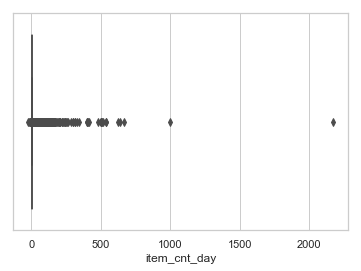

In [11]:
sns.boxplot(x=train_df['item_cnt_day'])

In [19]:
for i in range(1, 10):
    size = train_df[train_df.item_cnt_day.between(i, 10)].shape[0]
    print(f'{i}: {size}')
    
print('----------------------------------------------------------')
    
for i in range(10, 101, 10):
    size = train_df[train_df.item_cnt_day.between(i, 101)].shape[0]
    print(f'{i}: {size}')
    
print('----------------------------------------------------------')

for i in range(100, 2001, 200):
    size = train_df[train_df.item_cnt_day > i].shape[0]
    print(f'{i}: {size}')

1: 2918377
2: 289005
3: 94804
4: 47454
5: 27769
6: 17295
7: 10957
8: 6900
9: 3997
----------------------------------------------------------
10: 11801
20: 3643
30: 1626
40: 789
50: 421
60: 252
70: 147
80: 96
90: 39
100: 16
----------------------------------------------------------
100: 138
300: 23
500: 12
700: 2
900: 2
1100: 1
1300: 1
1500: 1
1700: 1
1900: 1


In [2]:
items_df = pd.read_csv(DATA + 'items.csv')
item_cats_df = pd.read_csv(DATA + 'item_categories.csv')
shops_df = pd.read_csv(DATA + 'shops.csv')

In [3]:
items_df.head()
item_cats_df.head()
shops_df.head()

,item_name,item_id,item_category_id
0,! ВО ВЛАСТИ НАВАЖДЕНИЯ (ПЛАСТ.) D,0,40
1,!ABBYY FineReader 12 Professional Edition Full...,1,76
2,***В ЛУЧАХ СЛАВЫ (UNV) D,2,40
3,***ГОЛУБАЯ ВОЛНА (Univ) D,3,40
4,***КОРОБКА (СТЕКЛО) D,4,40


,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4


,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [28]:
shops_df.shape
shops_df.nunique()

(60, 2)

shop_name    60
shop_id      60
dtype: int64

In [3]:
cities = [
    'Якутск', 'Адыгея', 'Балашиха', 'Волжский', 'Вологда', 'Воронеж',
    'Жуковский', 'Казань', 'Калуга', 'Коломна', 'Красноярск', 'Курск',
    'Москва', 'Н.Новгород', 'Мытищи', 'Новосибирск', 'РостовНаДону', 'Омск',
    'СПб', 'Самара', 'Сергиев Посад', 'Сургут', 'Томск', 'Тюмень', 'Уфа', 'Химки', 'Чехов', 'Ярославль'
]
pattern = '(' + '|'.join(cities) + ')'
pattern
shops_df['city'] = shops_df.shop_name.str.extract(pattern)

'(Якутск|Адыгея|Балашиха|Волжский|Вологда|Воронеж|Жуковский|Казань|Калуга|Коломна|Красноярск|Курск|Москва|Н.Новгород|Мытищи|Новосибирск|РостовНаДону|Омск|СПб|Самара|Сергиев Посад|Сургут|Томск|Тюмень|Уфа|Химки|Чехов|Ярославль)'

In [5]:
shops_df.city.fillna('-', inplace=True)

In [6]:
shops_df.to_csv(DATA + 'shops.csv', index=False)

In [4]:
shops_df[shops_df.city.isna()].shape
shops_df[shops_df.city.isna()].head()

(3, 3)

,shop_name,shop_id,city
9,Выездная Торговля,9,NaN
12,Интернет-магазин ЧС,12,NaN
55,Цифровой склад 1С-Онлайн,55,NaN


Duplicates:
* 0 -> 57
* 1 -> 58
* 11 -> 10
* 23 -> 24 ? the same mall, but different places

In [88]:
for city in cities:
    city
    shops_df[shops_df.city == city]

'Якутск'

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
57,"Якутск Орджоникидзе, 56",57,Якутск
58,"Якутск ТЦ ""Центральный""",58,Якутск


'Адыгея'

,shop_name,shop_id,city
2,"Адыгея ТЦ ""Мега""",2,Адыгея


'Балашиха'

,shop_name,shop_id,city
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха


'Волжский'

,shop_name,shop_id,city
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


'Вологда'

,shop_name,shop_id,city
5,"Вологда ТРЦ ""Мармелад""",5,Вологда


'Воронеж'

,shop_name,shop_id,city
6,"Воронеж (Плехановская, 13)",6,Воронеж
7,"Воронеж ТРЦ ""Максимир""",7,Воронеж
8,"Воронеж ТРЦ Сити-Парк ""Град""",8,Воронеж


'Жуковский'

,shop_name,shop_id,city
10,Жуковский ул. Чкалова 39м?,10,Жуковский
11,Жуковский ул. Чкалова 39м²,11,Жуковский


'Казань'

,shop_name,shop_id,city
13,"Казань ТЦ ""Бехетле""",13,Казань
14,"Казань ТЦ ""ПаркХаус"" II",14,Казань


'Калуга'

,shop_name,shop_id,city
15,"Калуга ТРЦ ""XXI век""",15,Калуга


'Коломна'

,shop_name,shop_id,city
16,"Коломна ТЦ ""Рио""",16,Коломна


'Красноярск'

,shop_name,shop_id,city
17,"Красноярск ТЦ ""Взлетка Плаза""",17,Красноярск
18,"Красноярск ТЦ ""Июнь""",18,Красноярск


'Курск'

,shop_name,shop_id,city
19,"Курск ТЦ ""Пушкинский""",19,Курск


'Москва'

,shop_name,shop_id,city
20,"Москва ""Распродажа""",20,Москва
21,"Москва МТРЦ ""Афи Молл""",21,Москва
22,Москва Магазин С21,22,Москва
23,"Москва ТК ""Буденовский"" (пав.А2)",23,Москва
24,"Москва ТК ""Буденовский"" (пав.К7)",24,Москва
25,"Москва ТРК ""Атриум""",25,Москва
26,"Москва ТЦ ""Ареал"" (Беляево)",26,Москва
27,"Москва ТЦ ""МЕГА Белая Дача II""",27,Москва
28,"Москва ТЦ ""МЕГА Теплый Стан"" II",28,Москва
29,"Москва ТЦ ""Новый век"" (Новокосино)",29,Москва


'Н.Новгород'

,shop_name,shop_id,city
34,"Н.Новгород ТРЦ ""РИО""",34,Н.Новгород
35,"Н.Новгород ТРЦ ""Фантастика""",35,Н.Новгород


'Мытищи'

,shop_name,shop_id,city
33,"Мытищи ТРК ""XL-3""",33,Мытищи


'Новосибирск'

,shop_name,shop_id,city
36,"Новосибирск ТРЦ ""Галерея Новосибирск""",36,Новосибирск
37,"Новосибирск ТЦ ""Мега""",37,Новосибирск


'РостовНаДону'

,shop_name,shop_id,city
39,"РостовНаДону ТРК ""Мегацентр Горизонт""",39,РостовНаДону
40,"РостовНаДону ТРК ""Мегацентр Горизонт"" Островной",40,РостовНаДону
41,"РостовНаДону ТЦ ""Мега""",41,РостовНаДону


'Омск'

,shop_name,shop_id,city
38,"Омск ТЦ ""Мега""",38,Омск


'СПб'

,shop_name,shop_id,city
42,"СПб ТК ""Невский Центр""",42,СПб
43,"СПб ТК ""Сенная""",43,СПб


'Самара'

,shop_name,shop_id,city
44,"Самара ТЦ ""Мелодия""",44,Самара
45,"Самара ТЦ ""ПаркХаус""",45,Самара


'Сергиев Посад'

,shop_name,shop_id,city
46,"Сергиев Посад ТЦ ""7Я""",46,Сергиев Посад


'Сургут'

,shop_name,shop_id,city
47,"Сургут ТРЦ ""Сити Молл""",47,Сургут


'Томск'

,shop_name,shop_id,city
48,"Томск ТРЦ ""Изумрудный Город""",48,Томск


'Тюмень'

,shop_name,shop_id,city
49,"Тюмень ТРЦ ""Кристалл""",49,Тюмень
50,"Тюмень ТЦ ""Гудвин""",50,Тюмень
51,"Тюмень ТЦ ""Зеленый Берег""",51,Тюмень


'Уфа'

,shop_name,shop_id,city
52,"Уфа ТК ""Центральный""",52,Уфа
53,"Уфа ТЦ ""Семья"" 2",53,Уфа


'Химки'

,shop_name,shop_id,city
54,"Химки ТЦ ""Мега""",54,Химки


'Чехов'

,shop_name,shop_id,city
56,"Чехов ТРЦ ""Карнавал""",56,Чехов


'Ярославль'

,shop_name,shop_id,city
59,"Ярославль ТЦ ""Альтаир""",59,Ярославль


In [92]:
test_df[test_df.shop_id == 0].shape
test_df[test_df.shop_id == 57].shape

(0, 3)

(5100, 3)

1.0     6464
2.0      350
3.0       77
4.0       21
0.0       17
5.0       14
8.0        6
6.0        6
7.0        3
10.0       2
20.0       1
16.0       1
9.0        1
Name: item_cnt_day, dtype: int64

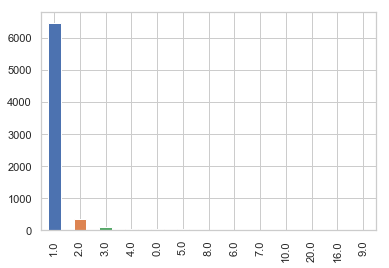

In [78]:
# value_counts().plot(kind='bar')
train_df[train_df.shop_id == 23].item_cnt_day.clip(0, 20).value_counts()
train_df[train_df.shop_id == 23].item_cnt_day.clip(0, 20).value_counts().plot(kind='bar')

1.0     47501
2.0      3571
3.0       926
4.0       375
5.0       178
0.0       103
6.0        89
7.0        66
8.0        49
10.0       37
9.0        35
11.0       23
20.0       22
12.0       15
14.0       10
13.0       10
16.0        7
17.0        6
18.0        3
19.0        3
15.0        3
Name: item_cnt_day, dtype: int64

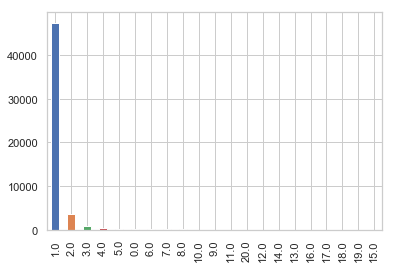

In [77]:
train_df[train_df.shop_id == 24].item_cnt_day.clip(0, 20).value_counts()
train_df[train_df.shop_id == 24].item_cnt_day.clip(0, 20).value_counts().plot(kind='bar')

In [79]:
item_cats_df.shape

(84, 2)

In [85]:
item_cats_df.head(42)
item_cats_df.tail(42)

,item_category_name,item_category_id
0,PC - Гарнитуры/Наушники,0
1,Аксессуары - PS2,1
2,Аксессуары - PS3,2
3,Аксессуары - PS4,3
4,Аксессуары - PSP,4
5,Аксессуары - PSVita,5
6,Аксессуары - XBOX 360,6
7,Аксессуары - XBOX ONE,7
8,Билеты (Цифра),8
9,Доставка товара,9


,item_category_name,item_category_id
42,"Книги - Артбуки, энциклопедии",42
43,Книги - Аудиокниги,43
44,Книги - Аудиокниги (Цифра),44
45,Книги - Аудиокниги 1С,45
46,Книги - Бизнес литература,46
47,"Книги - Комиксы, манга",47
48,Книги - Компьютерная литература,48
49,Книги - Методические материалы 1С,49
50,Книги - Открытки,50
51,Книги - Познавательная литература,51


In [87]:
cat_it = 70

items_df[items_df.item_category_id == cat_it].shape
items_df[items_df.item_category_id == cat_it].head()

(228, 3)

,item_name,item_id,item_category_id
1411,Angry Birds Star Wars (1 фигурка в ассортименте),1411,70
9320,Брелок Android зеленый,9320,70
9321,Брелок Assassin's Creed Rogue PU With Metal Ke...,9321,70
9322,Брелок Assassin's Creed Unity Keychain,9322,70
9323,Брелок Assassin's Creed Unity Metal Keyring wi...,9323,70


In [ ]:
# Duplicates:

# 0 -> 57
# 1 -> 58
# 11 -> 10
# 23 -> 24 ? the same mall, but different places

In [95]:
shops = {0: 57, 1: 58, 11: 10, 23: 24}

In [97]:
train_df.shop_id.replace(shops, inplace=True)
test_df.shop_id.replace(shops, inplace=True)

In [101]:
train_df.item_cnt_day.clip(0, 20, inplace=True)

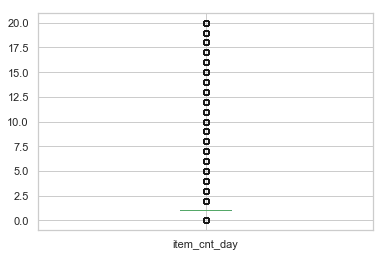

In [102]:
train_df.boxplot(column='item_cnt_day')

In [103]:
train_df.to_hdf(DATA + 'train_cleaned.h5', key='train', format='table', mode='w')
test_df.to_hdf(DATA + 'test_cleaned.h5', key='test', format='table', mode='w')

In [7]:
train_df = pd.read_hdf(DATA + 'train_cleaned.h5', key='train')
test_df = pd.read_hdf(DATA + 'test_cleaned.h5', key='test')

test_df.set_index('ID', inplace=True)

In [20]:
train_df.head()
test_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,0.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


,shop_id,item_id
ID,,
0,5,5037
1,5,5320
2,5,5233
3,5,5232
4,5,5268


In [11]:
grouped = train_df.groupby(['date_block_num', 'shop_id', 'item_id']).item_cnt_day.count()

In [15]:
train_df[(train_df.item_id == 700) & (train_df.shop_id == 2)].head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
37588,25.01.2013,0,2,700,199.0,1.0
42602,03.01.2013,0,2,700,199.0,1.0
42603,13.01.2013,0,2,700,199.0,1.0
42604,19.01.2013,0,2,700,199.0,1.0
671445,06.07.2013,6,2,700,199.0,1.0


In [24]:
test_df['dummy'] = 1

In [25]:
grouped_test = test_df.groupby(['shop_id', 'item_id']).dummy.count()
grouped_test[grouped_test > 1]

In [ ]:
train_df.groupby(['date_block_num', 'shop_id', 'item_id']).item_cnt_day.count()

In [36]:
train_df[(train_df.item_id == 2973) & (train_df.shop_id == 32)].shape
train_df[(train_df.item_id == 2973) & (train_df.shop_id == 32)].head(13)

(13, 6)

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
67427,29.01.2013,0,32,2973,2499.0,1.0
67428,25.01.2013,0,32,2973,2499.0,1.0
67429,22.01.2013,0,32,2973,2499.0,1.0
67430,21.01.2013,0,32,2973,2499.0,1.0
67431,18.01.2013,0,32,2973,2499.0,1.0
67432,17.01.2013,0,32,2973,2499.0,1.0
67433,15.01.2013,0,32,2973,2499.0,3.0
187844,05.02.2013,1,32,2973,2499.0,1.0
187845,14.02.2013,1,32,2973,2499.0,1.0
484682,23.05.2013,4,32,2973,1249.0,1.0


In [35]:
train_df.loc[484683, 'item_price'] = 2499.0

In [38]:
sums = train_df.groupby(['date_block_num', 'shop_id', 'item_id']).item_cnt_day.sum()
sums = sums.reset_index()

In [41]:
train_df.shape

(2935849, 6)

In [42]:
train_df.drop_duplicates(subset=['date_block_num', 'shop_id', 'item_id'], keep='last', inplace=True)

In [43]:
train_df.shape
train_df.head()

(1607622, 6)

In [49]:
train_df = train_df.merge(sums, on=['date_block_num', 'shop_id', 'item_id'], how='left')
train_df.drop('item_cnt_day_x', inplace=True, axis=1)
train_df.rename({'item_cnt_day_y': 'item_cnt_day'}, inplace=True, axis=1)

train_df.shape
train_df.head()

In [64]:
train_df.item_cnt_day.clip(0, 30, inplace=True)

In [65]:
train_df.to_hdf(DATA + 'train_cleaned.h5', key='train', format='table', mode='w')

In [4]:
shops_df.head()

,shop_name,shop_id,city
0,"!Якутск Орджоникидзе, 56 фран",0,Якутск
1,"!Якутск ТЦ ""Центральный"" фран",1,Якутск
2,"Адыгея ТЦ ""Мега""",2,Адыгея
3,"Балашиха ТРК ""Октябрь-Киномир""",3,Балашиха
4,"Волжский ТЦ ""Волга Молл""",4,Волжский


In [5]:
cities = shops_df.city.unique()

In [7]:
values = {'city': cities, 'city_id': range(1, len(cities) + 1)}
cities_df = pd.DataFrame.from_dict(values)

In [10]:
cities_df.shape
cities_df

(29, 2)

,city,city_id
0,Якутск,1
1,Адыгея,2
2,Балашиха,3
3,Волжский,4
4,Вологда,5
5,Воронеж,6
6,-,7
7,Жуковский,8
8,Казань,9
9,Калуга,10


In [12]:
shops_df.shape
shops_df = shops_df.merge(cities_df, how='left', on='city')

(60, 3)

In [18]:
shops_df.head()

,shop_name,shop_id,city_id
0,"!Якутск Орджоникидзе, 56 фран",0,1
1,"!Якутск ТЦ ""Центральный"" фран",1,1
2,"Адыгея ТЦ ""Мега""",2,2
3,"Балашиха ТРК ""Октябрь-Киномир""",3,3
4,"Волжский ТЦ ""Волга Молл""",4,4


In [15]:
shops_df.drop('city', inplace=True, axis=1)

In [16]:
shops_df.to_csv(DATA + 'shops.csv', index=False)

In [17]:
cities_df.to_csv(DATA + 'cities.csv', index=False)

In [19]:
train_df = pd.read_hdf(DATA + 'features.h5', key='features')
test_df =  pd.read_hdf(DATA + 'features_test.h5', key='data')

test_df.set_index('ID', inplace=True)

In [20]:
train_df.shape
test_df.shape

(1544806, 63)

(214200, 62)

In [21]:
train_df = train_df.merge(cities_df, how='left', on='city')
train_df.drop('city', inplace=True, axis=1)

test_df = test_df.merge(cities_df, how='left', on='city')
test_df.drop('city', inplace=True, axis=1)

In [24]:
train_df.to_hdf(DATA + 'features.h5', key='features', format='table', mode='w')
test_df.to_hdf(DATA + 'features_test.h5', key='data', format='table', mode='w')

In [2]:
train_df = pd.read_hdf(DATA + 'train_cleaned.h5', key='train')
test_df = pd.read_hdf(DATA + 'test_cleaned.h5', key='test')

In [3]:
train_df.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,05.01.2013,0,25,2552,899.00,1.0
2,06.01.2013,0,25,2554,1709.05,1.0
3,15.01.2013,0,25,2555,1099.00,1.0
4,10.01.2013,0,25,2564,349.00,1.0


In [4]:
train_df.nunique()

date               1034
date_block_num       34
shop_id              56
item_id           21807
item_price        12888
item_cnt_day         31
dtype: int64

In [6]:
test_df.nunique()

ID         214200
shop_id        42
item_id      5100
dtype: int64

In [7]:
test_df['shop_item'] = test_df.astype(str).shop_id + '_' + test_df.astype(str).item_id
train_df['shop_item'] = train_df.astype(str).shop_id + '_' + train_df.astype(str).item_id

In [10]:
test_shope_item_uniq = set(test_df.shop_item.unique())
train_shope_item_uniq = set(train_df.shop_item.unique())

tmp = [v for v in test_shope_item_uniq if v not in train_shope_item_uniq]

In [13]:
len(tmp), len(test_shope_item_uniq), len(train_shope_item_uniq)

(102697, 214200, 416881)

In [14]:
month_df = pd.DataFrame.from_dict({'date_block_num': range(0, 34), 'key': 0})

test_df['key'] = 0
tmp = test_df[['shop_item', 'key']]

tmp = tmp.merge(month_df, how='outer', on='key')

tmp.drop('key', inplace=True, axis=1)

tmp = tmp.merge(train_df, how='left', on=['shop_item', 'date_block_num'])

tmp.drop(['date', 'shop_id', 'item_id'], inplace=True, axis=1)

tmp['shop_id'] = tmp.shop_item.str.split('_').map(lambda x: x[0])
tmp['item_id'] = tmp.shop_item.str.split('_').map(lambda x: x[1])

grouped = tmp[tmp.item_price.notna()].groupby('item_id').item_price.median()

In [22]:
grouped.shape
grouped.head()

(4716,)

item_id
10003      99.0
10005     299.0
10007     399.0
10021     299.0
10027    1849.0
Name: item_price, dtype: float64

In [23]:
tmp = tmp.merge(grouped.to_frame(), how='left', left_on='item_id', right_index=True)

tmp.loc[tmp.item_price_x.isna(), 'item_price_x'] = tmp.loc[tmp.item_price_x.isna(), 'item_price_y']

tmp.drop('item_price_y', inplace=True, axis=1)
tmp.rename({'item_price_x': 'item_price'}, inplace=True, axis=1)

tmp.item_cnt_day.fillna(0, inplace=True)
tmp.item_cnt_day.clip(0, 20, inplace=True)

tmp.drop('shop_item', inplace=True, axis=1)

tmp.sort_values(by='date_block_num', inplace=True)

tmp.reset_index(inplace=True)

tmp.drop('index', inplace=True, axis=1)

In [31]:
tmp[tmp.item_cnt_day == 0].shape, tmp[tmp.item_cnt_day != 0].shape

((6680767, 5), (602033, 5))

In [32]:
tmp.to_hdf(DATA + 'train_augmented.h5', key='train', format='table', mode='w')

In [80]:
train_df = pd.read_hdf(DATA + 'train_augmented.h5', key='train')

In [81]:
train_df.head()

,date_block_num,item_price,item_cnt_day,shop_id,item_id
0,0,1999.0,0.0,5,5037
1,0,999.0,0.0,50,19034
2,0,799.0,0.0,35,15451
3,0,149.0,0.0,50,18968
4,0,299.0,0.0,50,18047


In [39]:
train_df = pd.read_hdf(DATA + 'train_augmented.h5', key='train')

In [40]:
train_df.head()

,date_block_num,item_price,item_cnt_day,shop_id,item_id
0,0,1999.0,0.0,5,5037
1,0,999.0,0.0,50,19034
2,0,799.0,0.0,35,15451
3,0,149.0,0.0,50,18968
4,0,299.0,0.0,50,18047


In [41]:
train_df['tmp'] = 0
train_df.loc[train_df.item_cnt_day != 0, 'tmp'] = 1

In [42]:
grouped = train_df.groupby('date_block_num')

In [9]:
tmp = grouped.tmp.sum() / grouped.tmp.count()

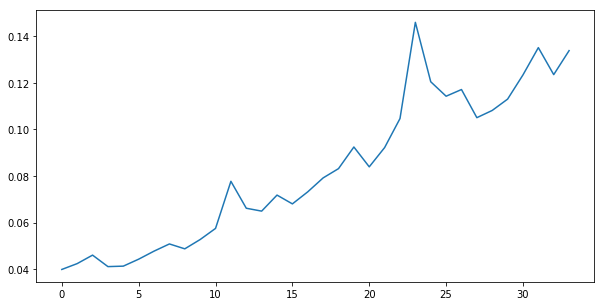

In [26]:
fgr = plt.figure(figsize=(10, 5))
plt.plot(tmp.index.values, tmp.tmp.values);

In [43]:
sums = grouped.item_cnt_day.sum()

In [44]:
sums.head()

date_block_num
0    21421.0
1    22834.0
2    27621.0
3    20139.0
4    20059.0
Name: item_cnt_day, dtype: float64

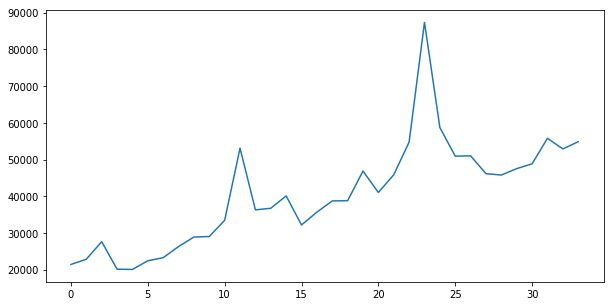

In [45]:
fgr = plt.figure(figsize=(10, 5))
plt.plot(sums.index.values, sums.values);

In [16]:
tmp = tmp.to_frame()

In [18]:
tmp['month'] = (tmp.index.values % 12) + 1

In [27]:
train_df.shape

train_df = train_df[train_df.date_block_num > 11]

train_df.shape

(7282800, 6)

(4712400, 6)

In [28]:
train_df.to_hdf(DATA + 'train_augmented.h5', key='train', format='table', mode='w')

In [19]:
tmp

,tmp,month
date_block_num,,
0,0.039897,1
1,0.042404,2
2,0.046046,3
3,0.041116,4
4,0.041317,5
5,0.044309,6
6,0.047759,7
7,0.050845,8
8,0.048749,9
